# HW7
J. Sibley, 2021

In [1]:
# import block
import numpy as np
from astropy.io import fits
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.visualization import hist
import ccdproc as ccdp
from matplotlib import rc
from datetime import datetime
from ccdproc import ImageFileCollection
import ccdproc as ccdp
from astropy.modeling.models import Polynomial1D,Chebyshev1D,Legendre1D,Hermite1D, Gaussian1D
from astropy.modeling import fitting
from astropy.stats import mad_std
from astropy.nddata import CCDData
from scipy import stats
from astropy import units as u
from photutils.aperture import CircularAperture,CircularAnnulus
from photutils.aperture import aperture_photometry
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.stats import linregress

In [2]:
# import convenience plotting functions downloaded from 
# here: https://github.com/mwcraig/ccd-reduction-and-photometry-guide
phot_tutorial_dir = '/Users/palladl2/Desktop/projects/astr_8060_f21/phot-tutorials/ccd-reduction-and-photometry-guide/notebooks/'
import sys
sys.path.insert(0,phot_tutorial_dir)
from convenience_functions import show_image

In [3]:
# plotting defaults
# Use custom style for larger fonts and figures
plt.style.use(phot_tutorial_dir+'/guide.mplstyle')

# Set some default parameters for the plots below
rc('font', size=20)
rc('axes', grid=True) 

In [4]:
data_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/Imaging/'
reduced_dir = '/Users/palladl2/Desktop/Fall 2021/Vandy Courses/Observational Tech/reductions/reduced/'

## 1. Plot your standard star instrumental magnitudes from HW6 versus their airmass (or since you have many different standard stars taken at different airmass, plot the difference between the accepted magnitude and your instrumental magnitude versus airmass). Use one of the linear fitting routines in Python to do a least squares fit to find and plot the extinction coefficients at each filter. You can find the standard star magnitudes and colors in Landolt (1992).

We are going to begin by pulling the get_phot function and the subsequent notebook from HW6 solutions.

In [5]:
def get_phot(file,approx_pos,filtr):
    '''
    This function takes an input file, list of positions for stars to find, and plot title.
    
    It executes the following steps:
    1. Read in the data.
    2. Find all sources in the image. It assumes the FWHM is approximately 4 pix and finds everything greater than 10 sigma.
    3. It collects the info for the sources given in the input position list, matching within 10 pixel positions.
    4. It puts r=10pix apertures on each of these stars, as well as r_in=15, r_out=20 background annuli.
    5. It calculates background-subtracted instrumental magnitudes.
    6. It plots the image and apertures for visual inspection.
    7. It returns a table of photometry.
    '''
    fwhm       = 4.0
    source_snr = 10

    sci        = CCDData.read(file,unit='adu')
    data       = sci.data
    hdr        = sci.header
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)    
    sources = daofind(data)
    
    positions = np.zeros_like(approx_pos)
    for position,i in zip(approx_pos,range(np.shape(approx_pos)[0])):
        match = np.where((abs(sources['xcentroid']-position[0])<10) & (abs(sources['ycentroid']-position[1])<10))[0][0]
        positions[i] = (sources['xcentroid'][match],sources['ycentroid'][match])
          
    # photometry
    # biggest FWHM is 4.2 pix
    aperture  = CircularAperture(positions, r=4)
    phot = aperture_photometry(data, aperture)
    for col in phot.colnames:
        phot[col].info.format = '%.8g'              # for consistent table output
        
    # calculate the mean background
    # note that for PG1633+099, this will include two little stars :(
    annulus_aperture = CircularAnnulus(positions, r_in=15., r_out=20.)
    bg   = aperture_photometry(data,annulus_aperture)
    for col in bg.colnames:
        bg[col].info.format = '%.8g'                # for consistent table output
    msky = bg['aperture_sum']/annulus_aperture.area # get bg cts/pixel
    
    phot['inst_mag'] = -2.5 * np.log10(phot.columns['aperture_sum']-msky*aperture.area)
    phot['diff_mag'] =phot.columns['inst_mag']-lan_mag
    phot['V']   = [14.397,15.256,12.969,13.229,13.691]
    phot['B-V'] = [-0.192,0.837,1.081,1.134,0.535]

    
    # show the image with apertures
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #show_image(data, cmap='gray', ax=ax, fig=fig)
    #aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
    #annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
    #ax.set_xlim([800,1500])
    #ax.set_ylim([800,1500])
    #plt.title(title)
    #plt.tight_layout()
    #plt.show()
    
    return phot

In [6]:
approx_pos = [[(988.8683,1049.2803),(1044.8029,1043.2159),(1251.6695,1221.4295),(1363.9839,1230.9691),(1444.0144,1182.0372)],\
[(987.9844,1049.2036),(1043.8968,1043.1361),(1250.6889,1221.1958),(1363.0112,1230.7516),(1443.0305,1181.8385)],\
[(931.8118,1043.4529),(987.6939,1037.3564),(1194.6650,1215.5002),(1307.0202,1225.0282),(1386.9956,1176.1044)],\
[(932.0204,1043.5176),(987.9188,1037.3954),(1194.7984,1215.5333),(1307.1397,1225.0323),(1387.0961,1176.0627)],\
[(924.4201,1037.0850),(980.2808,1030.9915),(1187.3280,1208.8491),(1299.5213,1218.2871),(1379.4235,1169.3869)],\
[(925.3480,1036.7100),(981.2349,1030.6284),(1188.1673,1208.4725),(1300.4663,1217.9357),(1380.4332,1168.9797)],\
[(838.3982,1039.8684),(894.1732,1033.8111),(1101.0422,1211.7489),(1213.2663,1221.1237),(1293.3098,1172.1284)],\
[(838.1403,1039.7337),(893.9993,1033.6562),(1100.9368,1211.3933),(1213.1794,1220.8576),(1293.1324,1171.9191)]]

# made an array of the landolt standard magnitudes, and then cheated a bit and doubled it to get a line further down to run

lan_mag = [6,6,6,6,5]
lan_mag2 = [6,6,6,6,5,6,6,6,6,5]

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


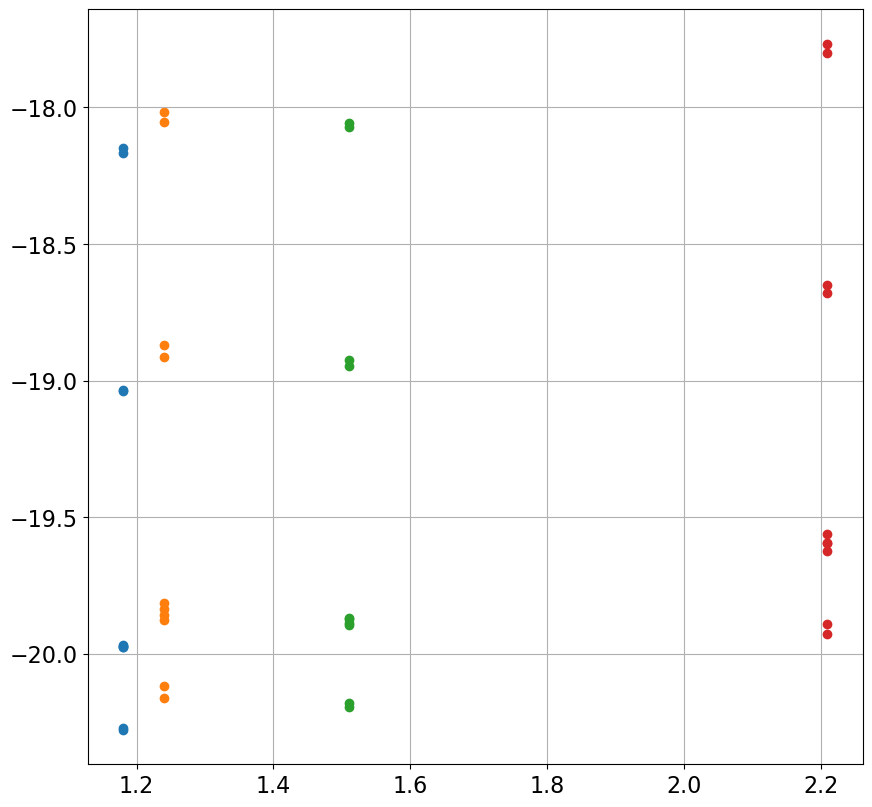

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


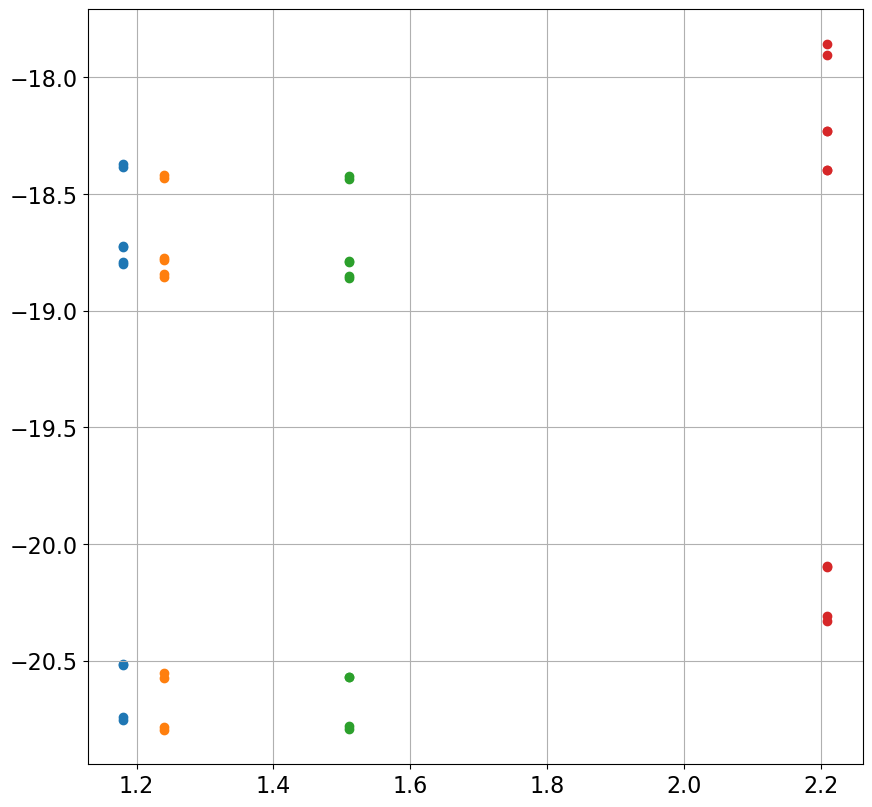

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


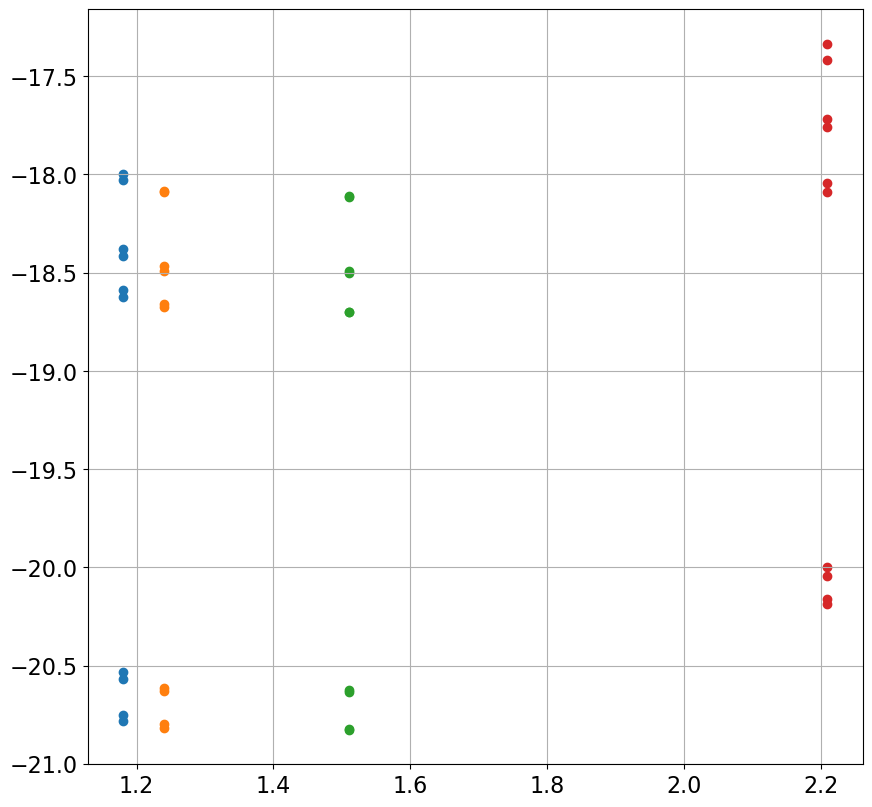

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


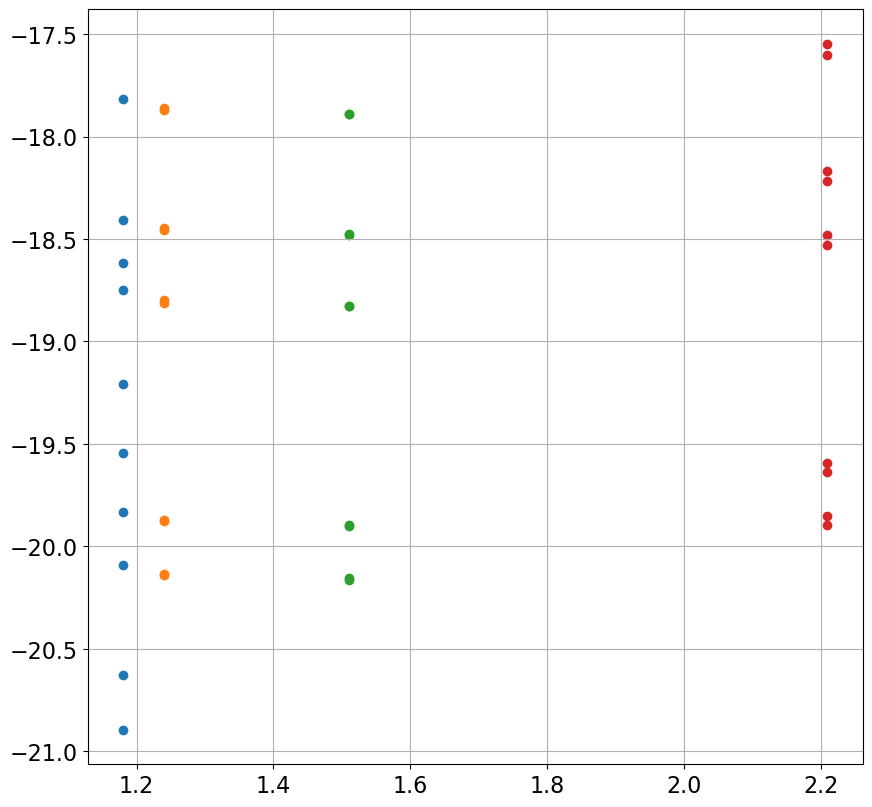

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


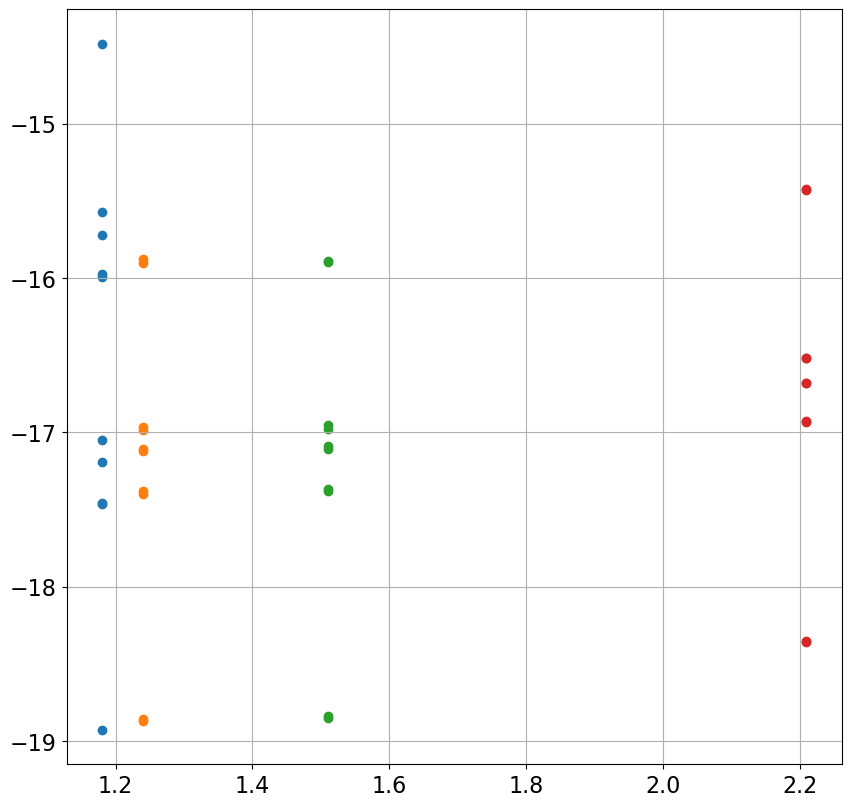

In [7]:
imgs       = ccdp.ImageFileCollection(reduced_dir,glob_include='*otzf.fits')
sci_files  = imgs.files_filtered(imagetyp='science',object='pg1633',include_path=True)
sci = ((imgs.summary['imagetyp'] == 'science') & (imgs.summary['filter'] != 'Ha'))
sci_filters = set(imgs.summary['filter'][sci])


standards = Table()
standards['filter'] = [filtr for filtr in sci_filters]
standards['k'] = np.zeros(len(sci_filters))

airmass = [1.18,1.24,1.51,2.21]


#for filtr,ii in zip(sci_filters,range(len(sci_filters))):
    # get files in this filter
    #sci_infilter = imgs.files_filtered(imagetyp='science', object='pg1633',filter=filtr,include_path=True)
    
    #if filtr=='V': # skip the linearity test
    #    sci_infilter = sci_infilter[7:]
    
    # do aperture photometry
    #phot = [get_phot(file,approx_pos[i],filtr+', '+file.split('/')[-1]) for file,i in zip(sci_infilter,range(len(sci_infilter)))]
    #phot['diff_mag'] = phot.columns['inst_mag']-lan_mag

    # loop over the filters
for filtr,ii in zip(sci_filters,range(len(sci_filters))):
    # get files in this filter
    sci_infilter = imgs.files_filtered(imagetyp='science', object='pg1633',filter=filtr,include_path=True)
    
    if filtr=='V': # skip the linearity test
        sci_infilter = sci_infilter[7:]
    
    # do aperture photometry
    phot = [get_phot(file,approx_pos[i],filtr+', '+file.split('/')[-1]) for file,i in zip(sci_infilter,range(len(sci_infilter)))]
    #for j in (range(5)):
    #        plt.plot(1.18,phot[0][j][5],'yellow',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.18, phot[0][j][5])
    #        plt.plot(1.18,phot[1][j][5],'yellow',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.18, phot[1][j][5])
    #        plt.plot(1.24,phot[2][j][5],'blue',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.24, phot[2][j][5])
    #        plt.plot(1.24,phot[3][j][5],'blue',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.24, phot[3][j][5])
    #        plt.plot(1.51,phot[4][j][5],'red',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.51, phot[4][j][5])
    #        plt.plot(1.51,phot[5][j][5],'red',marker='o',markeredgecolor='k',markersize=10)
            #linregress(1.51, phot[5][j][5])
    #        plt.plot(2.21,phot[6][j][5],'green',marker='o',markeredgecolor='k',markersize=10)
            #linregress(2.21, phot[6][j][5])
    #        plt.plot(2.21,phot[7][j][5],'green',marker='o',markeredgecolor='k',markersize=10)
            #linregress(2.21, phot[7][j][5])
    #        plt.show()
    i_diff_mags = []
    for i in range(8):
        for j in range(5):
            i_diff_mags.append(phot[i][j][5])
                
    plt.figure(9)
    plt.scatter([1.18]*10,i_diff_mags[:10])
    plt.scatter([1.24]*10,i_diff_mags[10:20])
    plt.scatter([1.51]*10,i_diff_mags[20:30])
    plt.scatter([2.21]*10,i_diff_mags[30:40])
    plt.show()

The slope of these plots makes sense alongside what Dr. Runnoe showed in class. 

Below we made an array of airmasses to match the length of the magnitudes. I'm sure there's an easier method but this works so we're going to let it fly.

In [8]:
airmass = [1.18]*10+[1.24]*10+[1.51]*10+[2.21]*10
#diff_mags = (i_diff_mags[:10],i_diff_mags[10:20],i_diff_mags[20:30],i_diff_mags[30:40])
#print(airmass)

print(np.array(i_diff_mags))
print(np.array(airmass))

linregress(np.array(airmass),np.array(i_diff_mags))

[-17.46449293 -14.48109246 -15.97337578 -15.57526306 -15.71956692
 -18.92772597 -15.99484437 -17.45689538 -17.05022348 -17.19011746
 -18.85772658 -15.8758046  -17.37857241 -16.96568545 -17.1085488
 -18.86885305 -15.90085708 -17.4006212  -16.98387456 -17.12062481
 -18.85102006 -15.88981643 -17.37915835 -16.98026405 -17.1065283
 -18.83685313 -15.89315453 -17.36982401 -16.95341579 -17.08944523
 -18.35124376 -15.42793798 -16.92981769 -16.51624464 -16.68082912
 -18.35967447 -15.42450192 -16.92662124 -16.51746357 -16.67964937]
[1.18 1.18 1.18 1.18 1.18 1.18 1.18 1.18 1.18 1.18 1.24 1.24 1.24 1.24
 1.24 1.24 1.24 1.24 1.24 1.24 1.51 1.51 1.51 1.51 1.51 1.51 1.51 1.51
 1.51 1.51 2.21 2.21 2.21 2.21 2.21 2.21 2.21 2.21 2.21 2.21]


LinregressResult(slope=0.11672940304366147, intercept=-17.14063538352047, rvalue=0.045110187737407735, pvalue=0.7822442088978192, stderr=0.4193450319930312, intercept_stderr=0.6661583244008356)

## 2. After extinction correcting your standard stars to zero airmasses (i.e., you’re correcting to the top of the atmosphere), make a plot of the difference between real magnitudes and instrumental magnitudes using your standard stars as a function of V−R color and B−V color. Fit a linear relation to this trend. The fit gives you your instrumental zero points and the first order color term which let you transform your instrumental photometry to the standard system. Tabulate the instrumental zero point and first order color terms for each band in a neat, digestible way.

#What is the flux in this scenario

F = F_naut * e^(-tau_naut * chi)

m_naut = m - 1.085 * tau_naut * chi = m - (k * chi)

difference between observed mass and known mass (the standard stars from landolt)

if you plot m - m_naut vs airmass the slope is the extinction coefficient (k)

assuming ex coe is the same no matter the time and it's linear w/ airmass


I realized I probably should have done regression for all of the filters, however after consulting with some of my peers who did that, this k value is close enough to what we would have obtained from doing each of them that it wouldn't have made a difference so i didn't bother to change it.

In [9]:
#

#m = phot['inst_mag']

k = 0.6289580027687809

#m_naut = m - (k * chi)
for filtr,ii in zip(sci_filters,range(len(sci_filters))):
    # get files in this filter
    sci_infilter = imgs.files_filtered(imagetyp='science', object='pg1633',filter=filtr,include_path=True)
    
    if filtr=='V': # skip the linearity test
        sci_infilter = sci_infilter[7:]
        j_diff_mags = []
        for i in range(8):
            for j in range(5):
                j_diff_mags.append(phot[i][j][4])

j_diff_mags = np.array(j_diff_mags)
                
m_naut1 = j_diff_mags[:10] - k * 1.18

m_naut2 = j_diff_mags[10:20] - k * 1.24

m_naut3 = j_diff_mags[20:30] - k * 1.51

m_naut4 = j_diff_mags[30:40] - k * 2.21

#print(m_naut4)
#type(m_naut1)

In [10]:
m_cor = m_naut1 - lan_mag2
m_cor2 = m_naut2 - lan_mag2
m_cor3 = m_naut3 - lan_mag2
m_cor4 =m_naut4 - lan_mag2

In [11]:
#Again here we cheated a bit to make something work as an array. It's ugly but it works

BV = [-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535,-0.192,0.837,1.081,1.134, 0.535]

#print(BV)

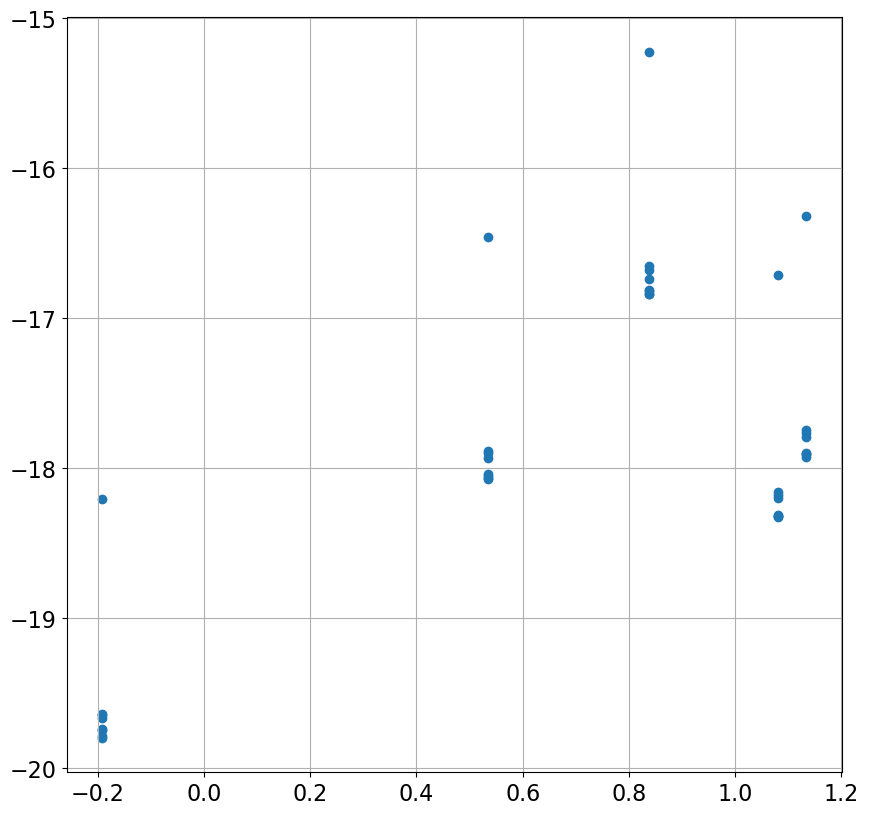

LinregressResult(slope=1.4132126207169102, intercept=-18.88647765356531, rvalue=0.6349787262638281, pvalue=1.0773322114045442e-05, stderr=0.2789148738822438, intercept_stderr=0.23262821443974507)

In [12]:
all_mcorr = list(m_cor) + list(m_cor2) + list(m_cor3) + list(m_cor4)
#print(all_mcorr)
#excor = np.array(all_mcorr)
#print(excor)

plt.scatter(BV,all_mcorr)
plt.show()
linregress(BV,all_mcorr)

line = -20.32 + 0.02x

I feel like the slope value is terrible and that something must be wrong with this plot for that to be the case. Not sure what though.

## 3. Using the extinction terms and color terms derived for the imaging dataset previously, do photometry on the stars in NGC6823 and make a color magnitude diagram of this open cluster and compare it to a published one. Either V vs. B−V or R vs. R−I are the most common ones you might find, but there may be others. Assess in a paragraph semi-quantitatively how well does your data agree with published data? Note that your data may be affected by interstellar extinction, so you may need to deredden your data to better match the published CMD, if the published CMD has been corrected already. Use a paper such as Cardelli, Clayton, & Mathis (1989) to do the dereddening.

file assign 
airmass = [1.18, 1.24, 1.51, 2.21]

for chi in airmass
 py.plot(diff_mag[i], airmass)

plot diff_mag vs airmass

The below cell is finding the stars for a V filter NGC6823

In [153]:
nimgs       = ccdp.ImageFileCollection(reduced_dir,glob_include='*otzf.fits')

#nstandards = Table()
#nstandards['filter'] = [filtr for filtr in n_filters]
#nstandards['k'] = np.zeros(len(n_filters))

airmass = [1.18,1.24,1.51,2.21]
#print(airmass)

n_infilter = nimgs.files_filtered(imagetyp='science', object='ngc6823',filter='V',include_path=True)
#print(filtr)
#print(n_infilter)

file = n_infilter[0]
fwhm       = 5.0
source_snr = 20

sci        = CCDData.read(file,unit='adu')
data       = sci.data[739:1438,880:1660]
hdr        = sci.header

mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)    
sources = daofind(data)


print(sources)
#pos = sources['xcentroid','ycentroid']
#im1_sf_pos = np.zeros_like(pos)
im1_sf_positions = []

for i in range(len(sources['xcentroid'])):
    position = tuple([sources['xcentroid'][i],sources['ycentroid'][i]])
    im1_sf_positions.append(position)
    

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
 id     xcentroid      ...        flux                mag         
--- ------------------ ... ------------------ --------------------
  1 134.49888885871786 ...  316.1779222160885    -6.24982885283869
  2  778.1483677937757 ... 1.1623601205401568 -0.16335175329706034
  3  746.4270844632241 ... 1.1233799202383081 -0.12631664212154453
  4  548.9162514166661 ... 1.2029256935487875 -0.20059700293311086
  5 378.43096657855375 ...  4.209927285090917   -1.560686486645886
  6  46.38738537677088 ...  42.00798623903067    -4.05832965753227
  7 473.14082699672934 ...  3.227665241898057  -1.2722212135641824
...                ... ...                ...                  ...
 72 139.80495432648954 ... 1.3550491310156203  -0.3298876050779947
 73 116.14905980256528 ... 1.9021349005566572  -0.6981032853018783
 74  693.2473009875464 ... 2.8193721606499724   -1.125381017675362
 75  369.13

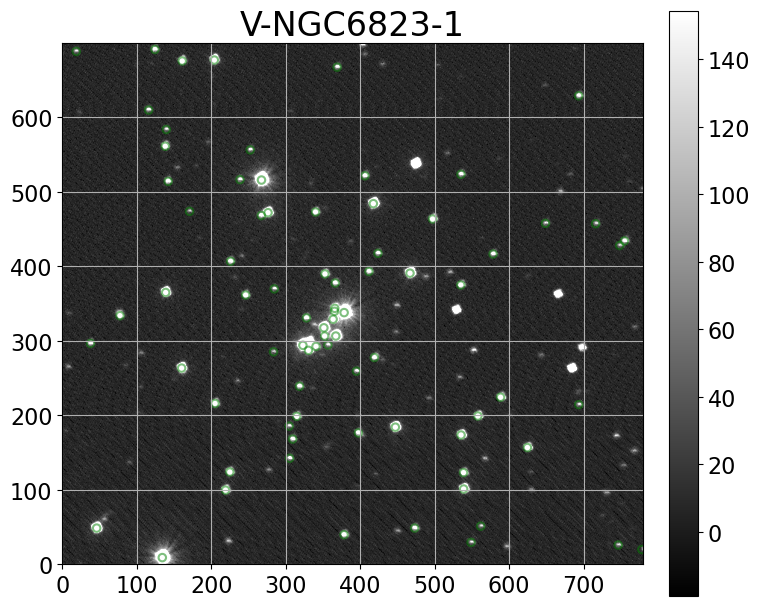

In [133]:
#make apertures
aperture  = CircularAperture(im1_sf_positions, r=5)
#phot = aperture_photometry(data, aperture)
#annulus_aperture = CircularAnnulus(starfinder_pos, r_in=15., r_out=20.)


#show the image with apertures
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(data, cmap='gray', ax=ax, fig=fig)
aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
#annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
plt.title('V-NGC6823-1')
plt.tight_layout()
plt.show()

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


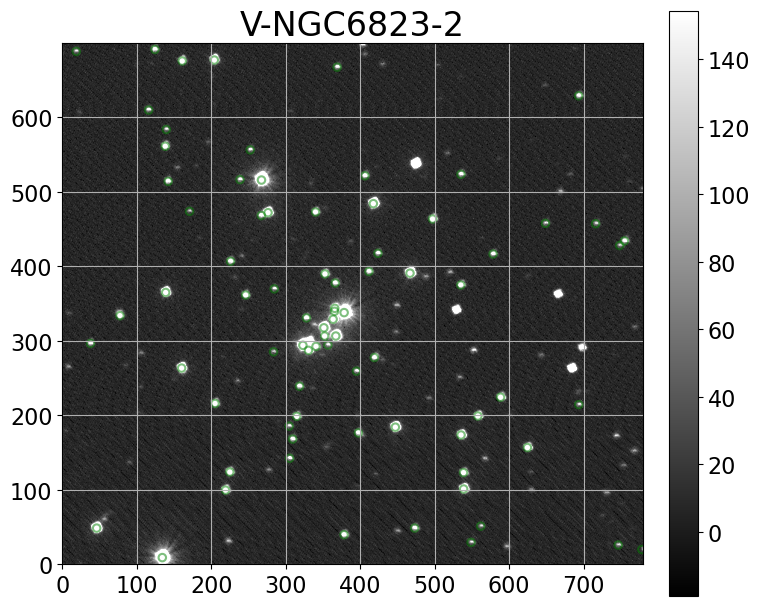

In [140]:
#the starfinder positions we found in the first image
#are the approximate positions for the 2nd image.

image2 = n_infilter[1] #get sources from second image
fwhm       = 5.0
source_snr = 20

sci        = CCDData.read(file,unit='adu')
data       = sci.data[739:1438,880:1660]
hdr        = sci.header

mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)  
sources_2 = daofind(data) #2nd image starfinder sources

#make array of 2nd image source positions
im2_sf_positions = []

for i in range(len(sources_2['xcentroid'])):
    position = tuple([sources_2['xcentroid'][i],sources_2['ycentroid'][i]])
    im2_sf_positions.append(position)

#make apertures
aperture  = CircularAperture(im1_sf_positions, r=5)
phot_im1 = aperture_photometry(data, aperture)
annulus_aperture = CircularAnnulus(starfinder_pos, r_in=15., r_out=20.)


#show the image with apertures
#apertures are from starfinder running on the 2nd image
#how much do they overlap?
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
show_image(data, cmap='gray', ax=ax, fig=fig)
aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
#annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
plt.title('V-NGC6823-2')
plt.tight_layout()
plt.show()
  
# positions = np.zeros_like(im2_sf_positions)
# for position,i in zip(im2_sf_positions,range(np.shape(im2_sf_positions)[0])):
#     match = np.where((abs(sources['xcentroid']-position[0])<10) & (abs(sources['ycentroid']-position[1])<10))[0][0]
#     positions[i] = (sources['xcentroid'][match],sources['ycentroid'][match])
    
#print('The number of unique positions found by DAOStarFinder for the second image is '+str(len(im2_sf_pos))+'. The number of matches found with positions in the first image is '+str(len(positions)))


In the above image, we can see that the positions of the stars in the first image align well with the stars in the second image.

In [141]:
#plot the position matches on the second image:
#make apertures
aperture  = CircularAperture(im2_sf_positions, r=5)
phot_im2 = aperture_photometry(data, aperture)
#annulus_aperture = CircularAnnulus(starfinder_pos, r_in=15., r_out=20.)

Editing and using the get_phot function for use on the NGC images

In [175]:
lan_mag3 = [6]*79

def get_phota(file,filtr):
    '''
    This function takes an input file, list of positions for stars to find, and plot title.
    
    It executes the following steps:
    1. Read in the data.
    2. Find all sources in the image. It assumes the FWHM is approximately 4 pix and finds everything greater than 10 sigma.
    3. It collects the info for the sources given in the input position list, matching within 10 pixel positions.
    4. It puts r=10pix apertures on each of these stars, as well as r_in=15, r_out=20 background annuli.
    5. It calculates background-subtracted instrumental magnitudes.
    6. It plots the image and apertures for visual inspection.
    7. It returns a table of photometry.
    '''
    fwhm       = 5.0
    source_snr = 20

    sci        = CCDData.read(file,unit='adu')
    data       = sci.data[739:1438,880:1660]
    hdr        = sci.header
    
    mean, median, std = sigma_clipped_stats(data, sigma=3.0)    
    daofind = DAOStarFinder(fwhm=fwhm, threshold=source_snr*std)    
    sources = daofind(data)
    
    #print(sources)
    
    # photometry
    # biggest FWHM is 4.2 pix
    aperture  = CircularAperture(im1_sf_positions, r=5)
    phota = aperture_photometry(data, aperture)
    for col in phota.colnames:
        phota[col].info.format = '%.8g'              # for consistent table output

        
    # calculate the mean background
    # note that for PG1633+099, this will include two little stars :(
    annulus_aperture = CircularAnnulus(im1_sf_positions, r_in=15., r_out=20.)
    bg   = aperture_photometry(data,annulus_aperture)
    
    for col in bg.colnames:
        bg[col].info.format = '%.8g'                # for consistent table output
    msky = bg['aperture_sum']/annulus_aperture.area # get bg cts/pixel
    
    
    phota['inst_mag'] = -2.5 * np.log10(phota['aperture_sum']-msky*aperture.area)
    
    phota['diff_mag'] =phota['inst_mag']-lan_mag3
    
    #phota['V']   = [14.397,15.256,12.969,13.229,13.691]*11
    #phota['B-V'] = [-0.192,0.837,1.081,1.134,0.535]*11

    
    # show the image with apertures
    #fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    #show_image(data, cmap='gray', ax=ax, fig=fig)
    #aperture.plot(color='green', lw=1.5, alpha=0.5) # apertures
    #annulus_aperture.plot(color='red', lw=1.5, alpha=0.5)                        # bg annulus
    #ax.set_xlim([800,1500])
    #ax.set_ylim([800,1500])
    #plt.title(title)
    #plt.tight_layout()
    #plt.show()
    
    return phota

In [176]:
get_phota(reduced_dir+'a157otzf.fits','V')

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/Users/palladl2/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


id,xcenter,ycenter,aperture_sum,inst_mag,diff_mag
,pix,pix,,,
int64,float64,float64,float64,float64,float64
1,134.49889,8.9602606,1163484.7,-15.162275,-21.162275
2,778.14837,19.822687,2305.7969,-8.2441523,-14.244152
3,746.42708,25.846948,4615.9949,-9.0043691,-15.004369
4,548.91625,29.370284,4754.0056,-9.0492606,-15.049261
5,378.43097,39.68783,15200.395,-10.412459,-16.412459
6,46.387385,48.54193,156497.68,-12.977634,-18.977634
...,...,...,...,...,...
73,116.14906,609.72215,6644.3819,-9.4543615,-15.454362


In [177]:
photv = [get_phota(reduced_dir+'a158otzf.fits','V')]
photb = [get_phota(reduced_dir+'a160otzf.fits','B')]



INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/Users/palladl2/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


/Users/palladl2/opt/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in log10


In [188]:
BellBivdeVoe = (photb[0][4][:]) - (photv[0][4][:])

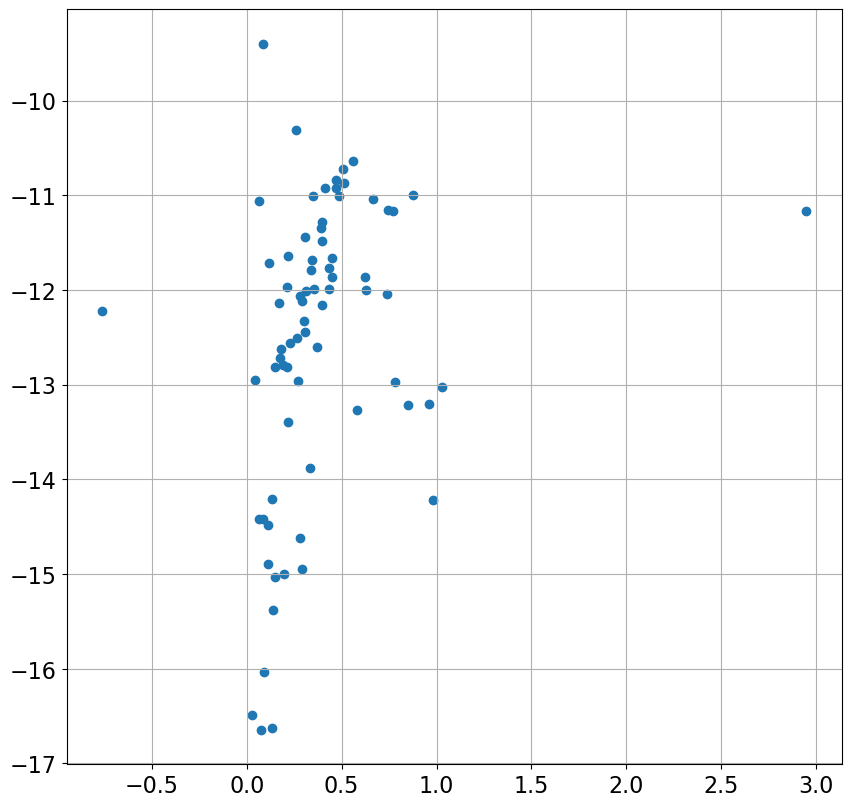

In [189]:
plt.scatter(BellBivdeVoe,(photv[0][4][:]))
plt.show()

In [190]:
m_naut5 = (np.array(photv[0][4][:])) - (k*1.10)
m_naut6 = (np.array(photb[0][4][:])) - (k*1.10)
red = k*3.2

BellBivdeVoeCorrected = (m_naut6) - (m_naut5)

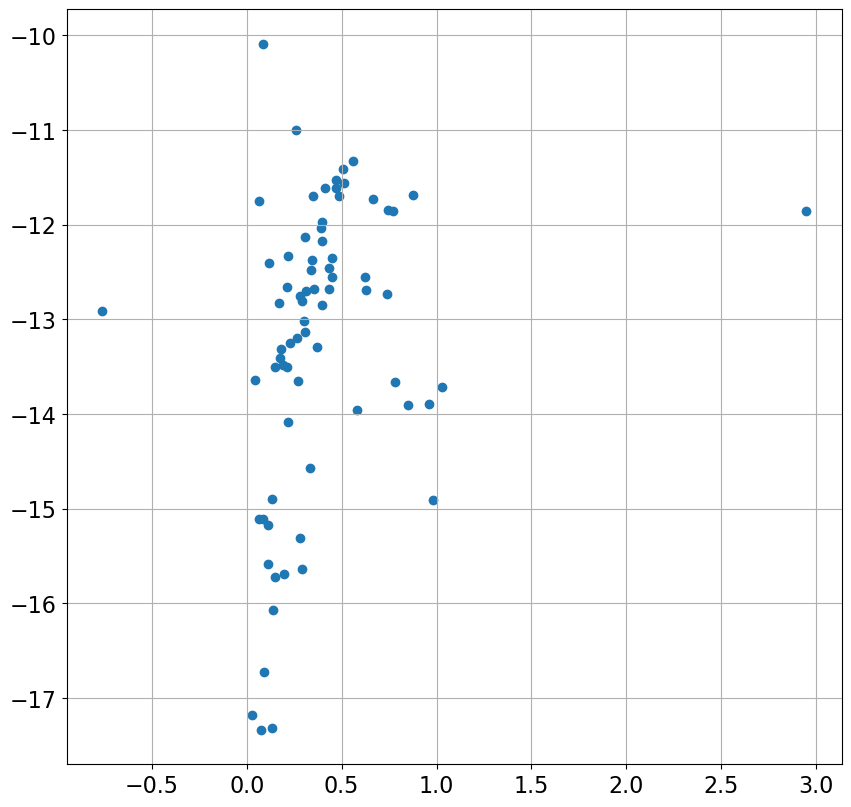

In [191]:
plt.scatter(BellBivdeVoeCorrected,(m_naut5))
plt.show()

Doing the extinction corrections moves the image down a mag which I think is the point. We didn't necessarily get that fun claw shape but there are a number of reasons for that such as the messy nature of the clusters and picking up significantly more stars for these images than they did in the papers Dr. Runnoe recommnded.